# Salary Scraping

Scrape salaries of postings from Northrop Grumman and Lockheed Martin in Colorado.  

In [1]:
import re
import time
import requests
import asyncio
import json
from pprint import pprint

import pandas as pd

import aiohttp                   # need install
import aiodns                    # need install
# import cchardet

from bs4 import BeautifulSoup
from selenium import webdriver   # need install
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import ElementClickInterceptedException, StaleElementReferenceException

In [ ]:

url = 'https://sjobs.brassring.com/TGnewUI/Search/Home/Home?partnerid=25037&siteid=5010&pk_vid=849c752faef245da16295886149c5fe9#keyWordSearch='

# Lockheed Martin Jobs

Before starting.  Download the latest ChromimumDriver from: https://sites.google.com/chromium.org/driver/.  ChromiumDriver is maintained by the Chromium team to support Selenium's WebDriver.


1. Go to base URL
2. Search empty string - get all jobs
3. Click 'Next' until all jobs are shown
4. Get links to all jobs
5. Go to jobs
6. Scrape data from pages

In [136]:
lockheed_baseurl = 'https://sjobs.brassring.com/TGnewUI/Search/Home/Home?partnerid=25037&siteid=5010&pk_vid=849c752faef245da16295903299c5fe9#home'

In [137]:
driver = webdriver.Chrome(r"C:\Users\cruot\Documents\2021\job-scraping\chromedriver_win32\chromedriver.exe")
driver.implicitly_wait(10)
driver.get(lockheed_baseurl)
keyword_field = driver.find_element_by_name('keyWordSearch')
keyword_field.send_keys('salary')
search_button = driver.find_element_by_id('searchControls_BUTTON_2')
search_button.click()
next_button = driver.find_element_by_id('showMoreJobs')

stop = False
for i in range(68):
    if stop:
        break
        
#     print(i)
#     next_button = driver.find_element_by_id('showMoreJobs')
    
    for _ in range(20):
        try:
            next_button.click()
        except ElementClickInterceptedException:
            print('err')
            time.sleep(0.5)
        except StaleElementReferenceException:
            print('Next is Stale, assume all postings are listed')
            stop = True
            break
        else:
            break

# time.sleep(1)
# driver.quit()

Next is Stale, assume all postings are listed


In [138]:
page_source = driver.page_source
job_soup = BeautifulSoup(page_source, 'html.parser')
job_soup

<html class="js canvas postmessage textshadow opacity cssanimations cssgradients csstransitions" lang="en-us" xml:lang="en-us"><!--<![endif]--><head><style type="text/css">@charset "UTF-8";[ng\:cloak],[ng-cloak],[data-ng-cloak],[x-ng-cloak],.ng-cloak,.x-ng-cloak,.ng-hide{display:none !important;}ng\:form{display:block;}.ng-animate-block-transitions{transition:0s all!important;-webkit-transition:0s all!important;}</style>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<meta content="text/html; charset=utf-8" http-equiv="content-type"/><script src="https://bam-cell.nr-data.net/1/0c4d2a794f?a=116819536&amp;v=1210.e2a3f80&amp;to=ZwEHZUAECkQFWhFbVl5LKGdxSixYCVwmXVdEFgpdXgAWGCxWCFc%3D&amp;rst=4724&amp;ck=1&amp;ref=https://sjobs.brassring.com/TGnewUI/Search/Home/Home&amp;ap=1089&amp;be=1425&amp;fe=4638&amp;dc=3976&amp;perf=%7B%22timing%22:%7B%22of%22:1630079026314,%22n%22:0,%22f%22:2,%22dn%22:34,%22dne%22:34,%22c%22:34,%22s%22:97,%22ce%22:169,%22rq%22:169,%22rp%22:1402,%22rpe%22:1641,

In [139]:
job_elems = job_soup.find_all('a', id=re.compile('^Job_'), href=True)
job_elems

[<a class="jobProperty jobtitle" href="https://sjobs.brassring.com/TGnewUI/Search/home/HomeWithPreLoad?partnerid=25037&amp;siteid=5010&amp;PageType=JobDetails&amp;jobid=655478" id="Job_0" ng-bind-html="$root.utils.htmlEncode(oQ.Value)" ng-class="oQ.ClassName" ng-click="handlers.jobClick($event, this)">Data Scientist</a>,
 <a class="jobProperty jobtitle" href="https://sjobs.brassring.com/TGnewUI/Search/home/HomeWithPreLoad?partnerid=25037&amp;siteid=5010&amp;PageType=JobDetails&amp;jobid=655293" id="Job_1" ng-bind-html="$root.utils.htmlEncode(oQ.Value)" ng-class="oQ.ClassName" ng-click="handlers.jobClick($event, this)">Contracts Negotiation Sr. Manager (Top Secret Clearance Required)</a>,
 <a class="jobProperty jobtitle" href="https://sjobs.brassring.com/TGnewUI/Search/home/HomeWithPreLoad?partnerid=25037&amp;siteid=5010&amp;PageType=JobDetails&amp;jobid=654850" id="Job_2" ng-bind-html="$root.utils.htmlEncode(oQ.Value)" ng-class="oQ.ClassName" ng-click="handlers.jobClick($event, this)">

In [140]:
driver.quit()

In [141]:
def process_lockheed_posting(html, verbose=False):    
    """Extract useful information from Lockheed's job posting.
    
    # - [x] Title
    # - [x] BU
    # - [x] Location
    # - [x] Job Posting #
    # - [x] Basic Qualifications
      # - [x] Eduction and Job Experience
    # - [x] Job Code
    # - [x] Description
    # - [x] Desired Skills
    # - [x] Pay Rate
      # Min Pay
      # Max Pay
    """
    data = {}  # populate and return data
    
    # parse HTML for useful job details
    soup = BeautifulSoup(html, 'html.parser')
    preload_json = json.loads(soup.find('input', id='preLoadJSON').get('value'))
    job_details = preload_json['Jobdetails']
    
    # extract information
    data['title'] = job_details['Title']    
    data['job_reqid'] = job_details['AutoOptionalReqId']
    
    salary_regex2 = re.compile(r'\$(.+?)\s*-\s*\$(.+?)\s*\.')
    for question in job_details['JobDetailQuestions']:
        if question['QuestionName'] == 'LMCareers Business Unit':
            data['bu'] = question['AnswerValue']
        
        elif question['QuestionName'] == 'State':
            data['state'] = question['AnswerValue']
        
        elif question['QuestionName'] == 'Colorado Pay Statement':
            m = salary_regex2.search(str(soup.body))
            if m:
                data['minpay'] = float(m.group(1).replace(',', ''))
                data['maxpay'] = float(m.group(2).replace(',', ''))
        
        elif question['QuestionName'] == 'Job Class':
            data['jobclass'] = question['AnswerValue']
        
        elif question['QuestionName'] == 'Job Code/Title':
            data['jobcode'] = question['AnswerValue']
        
        elif question['QuestionName'] == 'Job Description':
            data['description'] = question['AnswerValue']
        
        elif question['QuestionName'] == 'Basic Qualifications':
            data['qualifications'] = question['AnswerValue']
        
        elif question['QuestionName'] == 'Desired skills':
            data['skills'] = question['AnswerValue']
        
    if verbose:
        pprint(data)
        #     pprint(list(preload_json.keys()))
        #     pprint(preload_json['Jobdetails'])
    
    return data

In [142]:
async def parse_job_posting(idx, joblink):
    print(idx)
    link = joblink.get('href')
    async with aiohttp.ClientSession() as session:
        async with session.get(link) as resp:
            resp.raise_for_status()
            text = await resp.text()
            print(f'-{idx}')
            try:
                result = process_lockheed_posting(text, verbose=False)
            except:
                return {}
            else:
                return result

In [143]:
results = await asyncio.gather(*[parse_job_posting(i, joblink) for i, joblink in enumerate(job_elems)])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [144]:
df = pd.DataFrame(results).dropna()
print(len(df))
df.head(5)

417


title job_reqid      bu  \
3                        Software Engineer Associate  567761BR  SPACE    
5                    ISSO - Classified Cybersecurity  557645BR  SPACE    
6  Electronics Engineer, Space Protection, Mid Ca...  567877BR  SPACE    
7                           Hardware Design Engineer  565371BR    RMS    
8                 Senior Facility Operations Analyst  567666BR  SPACE    

                                 jobcode                     jobclass  \
3           E1071:Software Engineer Asc          Software Engineering   
5       E9372:Classified Cyber Security                      Security   
6        E1384:Electronics Engineer Stf       Electronics Engineering   
7           E1104:Hardware Engineer Stf   Systems Engineering: Other    
8  E5103:Facility Operations Analyst Sr                Administrative   

                                         description  \
3  Are you looking for an exciting career as a So...   
5  <b>Active Secret clearance is required with th...   
6  Are you ready to take your career to a new lev...   
7  This is the one you've been waiting for! Hardw...   
8  <b>The coolest jobs on this planet… or any oth...   

                                      qualifications  \
3  - Strong experience in software design and dev...   
5  • Active Secret clearance with the ability to ...   
6  • Bachelor of Science or higher from an accred...   
7  *Must currently hold an Active DoD Secret Secu...   
8  • Experience in property management operation ...   

                                              skills      state   minpay  \
3  - Active secret clearance. <br>- Mission Data ...  Colorado   67400.0   
5  • Understand Agile operations while possessing...  Colorado   79300.0   
6  • Experience with motor control applications i...  Colorado   97500.0   
7  -  Experience designing Juniper hardware in to...  Colorado   97500.0   
8  • Bachelor’s degree in project management, mai...  Colorado   68500.0   

     maxpay  
3  112300.0  
5  132100.0  
6  162500.0  
7  162500.0  
8  114100.0

## Process Job Codes

Not really sure on the levels, but trying to determine what the job codes mean.

Title | Level
------|-------
Asc   | L1
Engr  | L2
Sr    | L3
Stf   | L4
Sr Stf| L5

In [145]:
def process_jobcode(code):
    if 'Intern' in code:
        return 0
    if 'Asc' in code:
        return 1
    elif not any(ext in code for ext in ['Intern', 'Asc', 'Sr', 'Stf', 'Prin', 'Mgr']):
        return 2
    elif 'Sr' in code and 'Stf' not in code and not 'Mgr' in code:
        return 3
    elif 'Stf' in code and 'Sr' not in code:
        return 4
    elif 'Stf' in code and 'Sr' in code:
        return 5
    elif 'Prin' in code:
        return 6
    elif 'Mgr' in code and not 'Sr' in code:
        return 7
    elif 'Mgr' in code and 'Sr' in code:
        return 8
    else:
        return code

In [146]:
df['jobcode_id'] = df['jobcode'].apply(process_jobcode)
df.head(5)

title job_reqid      bu  \
3                        Software Engineer Associate  567761BR  SPACE    
5                    ISSO - Classified Cybersecurity  557645BR  SPACE    
6  Electronics Engineer, Space Protection, Mid Ca...  567877BR  SPACE    
7                           Hardware Design Engineer  565371BR    RMS    
8                 Senior Facility Operations Analyst  567666BR  SPACE    

                                 jobcode                     jobclass  \
3           E1071:Software Engineer Asc          Software Engineering   
5       E9372:Classified Cyber Security                      Security   
6        E1384:Electronics Engineer Stf       Electronics Engineering   
7           E1104:Hardware Engineer Stf   Systems Engineering: Other    
8  E5103:Facility Operations Analyst Sr                Administrative   

                                         description  \
3  Are you looking for an exciting career as a So...   
5  <b>Active Secret clearance is required with th...   
6  Are you ready to take your career to a new lev...   
7  This is the one you've been waiting for! Hardw...   
8  <b>The coolest jobs on this planet… or any oth...   

                                      qualifications  \
3  - Strong experience in software design and dev...   
5  • Active Secret clearance with the ability to ...   
6  • Bachelor of Science or higher from an accred...   
7  *Must currently hold an Active DoD Secret Secu...   
8  • Experience in property management operation ...   

                                              skills      state   minpay  \
3  - Active secret clearance. <br>- Mission Data ...  Colorado   67400.0   
5  • Understand Agile operations while possessing...  Colorado   79300.0   
6  • Experience with motor control applications i...  Colorado   97500.0   
7  -  Experience designing Juniper hardware in to...  Colorado   97500.0   
8  • Bachelor’s degree in project management, mai...  Colorado   68500.0   

     maxpay  jobcode_id  
3  112300.0           1  
5  132100.0           2  
6  162500.0           4  
7  162500.0           4  
8  114100.0           3

In [147]:
list(df['jobcode_id'])

[1,
 2,
 4,
 4,
 3,
 4,
 3,
 3,
 7,
 5,
 3,
 6,
 6,
 5,
 7,
 2,
 4,
 5,
 2,
 3,
 5,
 4,
 1,
 4,
 7,
 3,
 4,
 4,
 3,
 4,
 5,
 5,
 4,
 3,
 4,
 3,
 3,
 2,
 4,
 4,
 5,
 4,
 4,
 3,
 8,
 3,
 2,
 6,
 5,
 4,
 3,
 5,
 4,
 3,
 7,
 7,
 3,
 3,
 2,
 4,
 5,
 3,
 5,
 2,
 4,
 4,
 4,
 4,
 2,
 2,
 4,
 0,
 4,
 4,
 7,
 2,
 3,
 4,
 3,
 2,
 4,
 3,
 2,
 8,
 2,
 5,
 7,
 4,
 3,
 5,
 2,
 2,
 5,
 8,
 1,
 5,
 4,
 3,
 4,
 5,
 2,
 3,
 3,
 4,
 3,
 7,
 2,
 1,
 2,
 2,
 4,
 4,
 5,
 2,
 7,
 4,
 3,
 3,
 4,
 3,
 7,
 4,
 3,
 3,
 5,
 2,
 4,
 3,
 4,
 2,
 4,
 3,
 8,
 4,
 4,
 3,
 3,
 3,
 1,
 4,
 4,
 3,
 7,
 3,
 4,
 3,
 4,
 4,
 4,
 4,
 2,
 2,
 4,
 4,
 2,
 2,
 2,
 5,
 3,
 3,
 3,
 4,
 3,
 5,
 5,
 3,
 3,
 5,
 5,
 2,
 4,
 4,
 3,
 2,
 3,
 3,
 4,
 3,
 4,
 2,
 2,
 2,
 4,
 3,
 3,
 4,
 3,
 7,
 1,
 5,
 3,
 4,
 5,
 3,
 2,
 4,
 7,
 2,
 4,
 3,
 4,
 6,
 3,
 2,
 4,
 3,
 2,
 3,
 3,
 5,
 1,
 2,
 4,
 4,
 3,
 4,
 3,
 3,
 7,
 5,
 3,
 6,
 6,
 5,
 7,
 2,
 4,
 5,
 2,
 3,
 5,
 4,
 1,
 4,
 7,
 3,
 4,
 4,
 3,
 4,
 5,
 5,
 4,
 3,
 4,
 3,
 3,
 2,
 4,
 4,


## Process Job Class

In [158]:
def process_jobclass(jobclass):
    if 'systems' in jobclass.lower():
        return 1
    elif any(class_ in jobclass.lower() for class_ in ['artificial intelligence', 'data science', 'scientist']):
        return 2
    elif any(class_ in jobclass.lower() for class_ in ['information technology']):
        return 3
    elif any(class_ in jobclass.lower() for class_ in ['cyber', 'intelligence analysis', 'security']):
        return 4
    elif any(class_ in jobclass.lower() for class_ in ['human resources', 'finance', 'purchasing', 'contracts', 
                                                       'facilities', 'public', 'business', 'program', 'logistics',
                                                       'administrative']):
        return 5
    elif 'software' in jobclass.lower():
        return 6
    elif any(class_ in jobclass.lower() for class_ in ['engineering', 'guidance', 'inspection', 'qa']):
        return 7
    elif any(class_ in jobclass.lower() for class_ in ['manufacturing', 'technicians']):
        return 8
    elif 'management' in jobclass.lower():
        return 9
    else:
        return jobclass
    
# [process_jobclass(jobclass) for jobclass in df['jobclass'].unique()]

In [159]:
df['jobclass_id'] = df['jobclass'].apply(process_jobclass)
df.head(5)

title job_reqid      bu  \
3                        Software Engineer Associate  567761BR  SPACE    
5                    ISSO - Classified Cybersecurity  557645BR  SPACE    
6  Electronics Engineer, Space Protection, Mid Ca...  567877BR  SPACE    
7                           Hardware Design Engineer  565371BR    RMS    
8                 Senior Facility Operations Analyst  567666BR  SPACE    

                                 jobcode                     jobclass  \
3           E1071:Software Engineer Asc          Software Engineering   
5       E9372:Classified Cyber Security                      Security   
6        E1384:Electronics Engineer Stf       Electronics Engineering   
7           E1104:Hardware Engineer Stf   Systems Engineering: Other    
8  E5103:Facility Operations Analyst Sr                Administrative   

                                         description  \
3  Are you looking for an exciting career as a So...   
5  <b>Active Secret clearance is required with th...   
6  Are you ready to take your career to a new lev...   
7  This is the one you've been waiting for! Hardw...   
8  <b>The coolest jobs on this planet… or any oth...   

                                      qualifications  \
3  - Strong experience in software design and dev...   
5  • Active Secret clearance with the ability to ...   
6  • Bachelor of Science or higher from an accred...   
7  *Must currently hold an Active DoD Secret Secu...   
8  • Experience in property management operation ...   

                                              skills      state   minpay  \
3  - Active secret clearance. <br>- Mission Data ...  Colorado   67400.0   
5  • Understand Agile operations while possessing...  Colorado   79300.0   
6  • Experience with motor control applications i...  Colorado   97500.0   
7  -  Experience designing Juniper hardware in to...  Colorado   97500.0   
8  • Bachelor’s degree in project management, mai...  Colorado   68500.0   

     maxpay  jobcode_id  jobclass_id    avgpay    midpay  
3  112300.0           1            6   89850.0   89850.0  
5  132100.0           2            4  105700.0  105700.0  
6  162500.0           4            7  130000.0  130000.0  
7  162500.0           4            1  130000.0  130000.0  
8  114100.0           3            5   91300.0   91300.0

In [160]:
list(df['jobclass_id'])

[6,
 4,
 7,
 1,
 5,
 4,
 7,
 1,
 9,
 7,
 1,
 7,
 7,
 7,
 7,
 6,
 3,
 6,
 6,
 5,
 3,
 5,
 1,
 1,
 5,
 6,
 6,
 1,
 3,
 1,
 1,
 4,
 1,
 7,
 7,
 7,
 6,
 6,
 4,
 7,
 1,
 7,
 5,
 7,
 7,
 4,
 8,
 6,
 1,
 6,
 1,
 5,
 7,
 1,
 1,
 1,
 6,
 4,
 1,
 3,
 7,
 1,
 1,
 7,
 6,
 1,
 1,
 6,
 4,
 4,
 1,
 6,
 1,
 1,
 5,
 1,
 1,
 2,
 1,
 3,
 5,
 8,
 6,
 7,
 2,
 1,
 7,
 7,
 7,
 7,
 2,
 7,
 1,
 5,
 5,
 7,
 7,
 7,
 7,
 7,
 6,
 3,
 7,
 6,
 7,
 6,
 7,
 7,
 7,
 7,
 3,
 1,
 1,
 8,
 1,
 5,
 1,
 5,
 1,
 5,
 5,
 4,
 6,
 4,
 5,
 6,
 1,
 1,
 1,
 1,
 6,
 6,
 1,
 6,
 2,
 7,
 6,
 6,
 4,
 5,
 1,
 5,
 9,
 1,
 3,
 1,
 7,
 5,
 7,
 3,
 7,
 5,
 3,
 5,
 6,
 6,
 4,
 1,
 3,
 3,
 4,
 7,
 6,
 3,
 7,
 6,
 1,
 1,
 6,
 6,
 5,
 7,
 2,
 7,
 1,
 1,
 7,
 1,
 6,
 1,
 3,
 6,
 1,
 1,
 1,
 3,
 6,
 7,
 7,
 7,
 1,
 5,
 5,
 8,
 8,
 7,
 7,
 1,
 1,
 5,
 6,
 1,
 1,
 6,
 7,
 1,
 6,
 6,
 3,
 7,
 6,
 4,
 7,
 1,
 5,
 4,
 7,
 1,
 9,
 7,
 1,
 7,
 7,
 7,
 7,
 6,
 3,
 6,
 6,
 5,
 3,
 5,
 1,
 1,
 5,
 6,
 6,
 1,
 3,
 1,
 1,
 4,
 1,
 7,
 7,
 7,
 6,
 6,
 4,
 7,


## Process Pay

In [161]:
df['midpay'] = (df['minpay'] + df['maxpay']) / 2
df.head(5)

title job_reqid      bu  \
3                        Software Engineer Associate  567761BR  SPACE    
5                    ISSO - Classified Cybersecurity  557645BR  SPACE    
6  Electronics Engineer, Space Protection, Mid Ca...  567877BR  SPACE    
7                           Hardware Design Engineer  565371BR    RMS    
8                 Senior Facility Operations Analyst  567666BR  SPACE    

                                 jobcode                     jobclass  \
3           E1071:Software Engineer Asc          Software Engineering   
5       E9372:Classified Cyber Security                      Security   
6        E1384:Electronics Engineer Stf       Electronics Engineering   
7           E1104:Hardware Engineer Stf   Systems Engineering: Other    
8  E5103:Facility Operations Analyst Sr                Administrative   

                                         description  \
3  Are you looking for an exciting career as a So...   
5  <b>Active Secret clearance is required with th...   
6  Are you ready to take your career to a new lev...   
7  This is the one you've been waiting for! Hardw...   
8  <b>The coolest jobs on this planet… or any oth...   

                                      qualifications  \
3  - Strong experience in software design and dev...   
5  • Active Secret clearance with the ability to ...   
6  • Bachelor of Science or higher from an accred...   
7  *Must currently hold an Active DoD Secret Secu...   
8  • Experience in property management operation ...   

                                              skills      state   minpay  \
3  - Active secret clearance. <br>- Mission Data ...  Colorado   67400.0   
5  • Understand Agile operations while possessing...  Colorado   79300.0   
6  • Experience with motor control applications i...  Colorado   97500.0   
7  -  Experience designing Juniper hardware in to...  Colorado   97500.0   
8  • Bachelor’s degree in project management, mai...  Colorado   68500.0   

     maxpay  jobcode_id  jobclass_id    avgpay    midpay  
3  112300.0           1            6   89850.0   89850.0  
5  132100.0           2            4  105700.0  105700.0  
6  162500.0           4            7  130000.0  130000.0  
7  162500.0           4            1  130000.0  130000.0  
8  114100.0           3            5   91300.0   91300.0

## Visualize

In [162]:
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


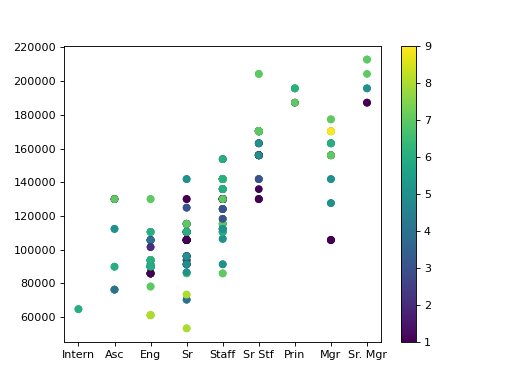

In [163]:
dfplot = df
plt.scatter(dfplot['jobcode_id'], dfplot['avgpay'], c=dfplot['jobclass_id'])
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['Intern', 'Asc', 'Eng', 'Sr', 'Staff', 'Sr Stf', 'Prin', 'Mgr', 'Sr. Mgr'])
plt.colorbar()

In [155]:
# df[df['avgpay'] > 180000]
# df[df['jobcode_id']]
len(job_elems)

564

In [164]:
df.to_csv('lockheed_salaries.csv', index=True)

In [ ]:
plotly.__version__

## Other

In [ ]:
html_posting = requests.get(job_elems[1].get('href'))
print(job_elems[1].get('href'))

In [ ]:
job_elems[1].text

In [ ]:
process_lockheed_posting(html_posting.text, verbose=True)

In [ ]:
salary_regex = re.compile(r'salary range for this position is (.+) \. ')

In [ ]:
for i, joblink in enumerate(job_elems[:2]):
    link = joblink.get('href')
    req = requests.get(link)
    soup = BeautifulSoup(req.content, 'html.parser')
    m = salary_regex.search(str(soup.body))
    if m is not None:
        print(f'{i} - {joblink.text} - {m.group(1)}')
    else:
        print(f'{i} - {joblink.text}')

# Northrop Grumman

In [2]:
northrop_url = 'https://www.northropgrumman.com/jobs/?country=United%20States%20of%20America&search'
northrop_url_func = lambda page: f'https://www.northropgrumman.com/jobs/page/{page}/?country=United%20States%20of%20America&search'
northrop_url_bad = northrop_url_func(1000)

In [3]:
pg1_soup = BeautifulSoup(requests.get(northrop_url).text)
pagination = pg1_soup.find('nav', class_='jobs-pagination')
m = re.search(r'\d+/(\d+)', pagination.text)
if m:
    page_count = int(m.group(1))

In [10]:
async def parse_northrop_job_pages(idx, pagelink):
    print(idx)
    async with aiohttp.ClientSession() as session:
        async with session.get(pagelink) as resp:
            resp.raise_for_status()
            text = await resp.text()
            return text

pages_html = await asyncio.gather(*[parse_northrop_job_pages(pg, northrop_url_func(pg)) for pg in range(1, page_count+1)])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161


In [11]:
len(pages_html)

161

In [12]:
def get_joblinks(page_text):
    pagesoup = BeautifulSoup(page_text)
    jobdivs = pagesoup.find_all('div', class_=re.compile('jobInfo'))
    links = [div.find('a').get('href') for div in jobdivs]
    return links

# get_joblinks(pages_html[0])

In [13]:
joblinks = []
for page_html in pages_html:
    page_joblinks = get_joblinks(page_html)
    joblinks += page_joblinks

In [14]:
batch_size = 350
batch_count = (len(joblinks) // batch_size)
link_batches = [joblinks[i*batch_size:(i+1)*batch_size] for i in range(batch_count)]
link_batches.append(joblinks[batch_count*batch_size:])

In [15]:
async def parse_links(idx, link):
    print(idx)
    try:
        async with aiohttp.ClientSession() as session:
            async with session.get(link) as resp:
                resp.raise_for_status()
                try:
                    text = await resp.text()
                except:
                    return None
                else:
                    return text
    except:
        return None
    
jobs_html = []
for i, links in enumerate(link_batches):
    print(f'Batch {i}')
    jobs_html += await asyncio.gather(*[parse_links(i, link) for i, link in enumerate(links)])

Batch 0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
27

248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
Batch 7
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
17

In [41]:
def parse_northrop_posting(text, url=None, verbose=False):
    data = {}  # return
    
    if url is not None:
        data['url'] = url
        
    # parse HTML for useful job details and extract information
    soup = BeautifulSoup(text)
    
    data['title'] = soup.find('main').find('h1').text
    
    m = re.search(r'>Requisition ID: (.+?)<', str(soup.find('main')))
    if m:
        data['job_reqid'] = m.group(1)
    
    jobdetails_list = soup.find('main').find('ul', class_='jobDetails').find_all('li')
    m = re.search('Category:\s*(\S+)\s*', jobdetails_list[0].text)
    if m:
        data['job_class'] = m.group(1)    
    m = re.search('Location:\s*.+, (\w+)', jobdetails_list[1].text)
    if m:
        data['state'] = m.group(1)
    
    
#     print(soup.text)
    m = re.search('Salary Range:\s*(\d+)\s*-\s*(\d+)', str(soup.text))
    if m:
#         if m.group(1) not in ['1', '2021'] and m.group(2) not in ['1', '8']:
        if float(m.group(1)) > 5_000 and float(m.group(2)) > 5_000:
            data['minpay'] = float(m.group(1))
            data['maxpay'] = float(m.group(2))
        
        m2 = re.search('Salary Range 2:\s*(\d+)\s*-\s*(\d+)', str(soup.text))
        if m2:
#             if m2.group(1) not in ['1', '2021'] and m2.group(2) not in ['1', '8']:
            if float(m2.group(1)) > 5_000 and float(m2.group(2)) > 5_000:
                data['minpay'] = [data['minpay'], float(m2.group(1))]
                data['maxpay'] = [data['maxpay'], float(m2.group(2))]
    
    if 'minpay' not in list(data):
        m = re.search(r'Salary Range:\s*\$(\d+,\d+)\s*-\s*\$(\d+,\d+)', str(soup.body))
        if m:
            data['minpay'] = float(m.group(1).replace(',', ''))
            data['maxpay'] = float(m.group(2).replace(',', ''))

        if 'minpay' not in list(data):
            m = re.search(r'Minimum Salary:\s*\$(\d+,\d+)', str(soup.body))
            if m:
                data['minpay'] = float(m.group(1).replace(',', ''))
        if 'maxpay' not in list(data):
            m = re.search(r'Maximum Salary:\s*\$(\d+,\d+)', str(soup.body))
            if m:
                data['maxpay'] = float(m.group(1).replace(',', ''))
    
    
#     print(data['minpay'])
#     print(data['maxpay'])
    
    data['description'] = soup.find('main').find('div', class_=re.compile('jobContent')).find('div').text

#     for question in job_details['JobDetailQuestions']:
#         if question['QuestionName'] == 'LMCareers Business Unit':
#             data['bu'] = question['AnswerValue']
        
#         elif question['QuestionName'] == 'Job Code/Title':
#             data['jobcode'] = question['AnswerValue']
        
#         elif question['QuestionName'] == 'Basic Qualifications':
#             data['qualifications'] = question['AnswerValue']
        
#         elif question['QuestionName'] == 'Desired skills':
#             data['skills'] = question['AnswerValue']
        
    if verbose:
        pprint(data)
        
    return data


test_urls = [
#     'https://www.northropgrumman.com/jobs/Elkton/Engineering/21016596/associate-electrical-engineer/',
#     'https://www.northropgrumman.com/jobs/Colorado-Springs/Engineering/21008197/engineer-software/',
#     'https://www.northropgrumman.com/jobs/Colorado-Springs/Information-Technology/21008312/principal-cyber-information-assurance-analyst/',
#     'https://www.northropgrumman.com/jobs/Linthicum/Information-Technology/21015127/computer-systems-architect/',
#     'https://www.northropgrumman.com/jobs/Fairfax/Business-Development/21011173/principal-sr-principal-competitive-intelligence-analyst/',
#     'https://www.northropgrumman.com/jobs/Schriever-AFB/Communications/R10000825/technical-editor-and-writer-6/',
    'https://www.northropgrumman.com/jobs/Annapolis/Engineering/R10001687/structural-principal-structural-engineer-2/',
]
for url in test_urls:
    print('======================================================')
    print('======================================================')
    parse_northrop_posting(requests.get(url).text, verbose=False)

In [42]:
joblinks[143]

'https://www.northropgrumman.com/jobs/Annapolis/Engineering/R10001687/structural-principal-structural-engineer-2/'

In [43]:
northrop_data = []
for i, job_html in enumerate(jobs_html):
    print(i)
    if job_html is not None:
        northrop_data.append(parse_northrop_posting(job_html, url=joblinks[i]))
print(len(northrop_data))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


In [51]:
dfnorthrop = pd.DataFrame(northrop_data).dropna(subset=['minpay', 'maxpay'])
print(len(dfnorthrop))
dfnorthrop.head(5)
# df[df['state']=='CO']
# # list(df['minpay'])

2329


url  \
0  https://www.northropgrumman.com/jobs/New-Town/...   
1  https://www.northropgrumman.com/jobs/Colorado-...   
2  https://www.northropgrumman.com/jobs/Tampa/Inf...   
3  https://www.northropgrumman.com/jobs/Tampa/Inf...   
5  https://www.northropgrumman.com/jobs/Chandler/...   

                                               title job_reqid  \
0       Pipeline Professional Technical – All Levels  21011751   
1          Principal System Engineer – Test (21-211)  21013959   
2  UNCLEARED Cyber Systems Engineer- Senior Princ...  21013895   
3                             Cyber Systems Engineer  21017790   
5                      Principal Engineer Mechanical  21014857   

        job_class state    minpay    maxpay  \
0  Administrative    ND   34500.0   57500.0   
1     Engineering    CO   83600.0  125400.0   
2     Information    FL  119244.0  178866.0   
3     Information    FL   77566.0  116394.0   
5     Engineering    AZ   79400.0  119200.0   

                                         description  
0  \n                  At Northrop Grumman, our e...  
1  \n                  At Northrop Grumman, our e...  
2  \n                  At Northrop Grumman, our e...  
3  \n                  At Northrop Grumman, our e...  
5  \n                  At Northrop Grumman, our e...

In [52]:
# dfnorthrop[dfnorthrop['title'].str.contains('/')].head(30)

In [53]:
dfnorthrop.loc[192]['url']

'https://www.northropgrumman.com/jobs/Gilbert/Engineering/21009906/integration-test-manager-3/'

## Jobclass

In [54]:
dfnorthrop['job_class'].unique()

array(['Administrative', 'Engineering', 'Information', 'Global', 'Flight',
       'Business', 'Facilities/Real', 'Research', 'Program', 'Legal',
       'Human', 'Technical', 'Manufacturing', 'Mission', 'Security',
       'Communications', 'Environmental,', 'Non-CJCS', 'Government'],
      dtype=object)

## Title

In [55]:
multiple_titles = [title for title in list(dfnorthrop['title']) if '/' in title or '-' in title]
slash_regex = re.compile(r'\w+\s*[/-]\s*\w+')

for title in multiple_titles:
    m = slash_regex.search(title)
    if m:
        print(m.group(0))

21-211
Engineer- Senior
Principal/Sr
Property/Asset
B-52
B-Shift
support /Casual
support /Casual
support /Casual
support /Casual
support /Casual
2 / Secret
Space / Satellite
Property/Asset
and/or
Principal / Senior
Principal / Senior
Programmer/Senior
Engineer/ Sr
21-339
21-336
Principal/ Sr
Principal/Sr
Principal/Sr
Principal/Sr
Prncpl / Sr
Op/Compl
Software/ Principal
Engineer/ Sr
21-307
21-348
TS/SCI
TS/SCI
TS/SCI
Structural/Principal
Administrator/ Principal
Engineer/ Electrical
GQM -163A
Engineer / Principal
2/3
Specialist- Melbourne
Principal / Electrical
Principal / Sr
Administrator/Senior
Specialist/ Sr
Principal/Senior
Principal/Sr
and/or
and/or
Engineer / Supplier
Analyst/ Principal
Engineer-TS
S/W
S/W
Lithium-Ion
Structural/Principal
Engineer / Principal
Analyst / Principal
Engineer/Principal
Software/ Principal
3/Lab
1/2
Principal / Senior
Principal / Senior
Engineer-I
Engineer/ Electronics
Management / Senior
Specialist/Sr
Principal/Senior
Principal/Senior
Scheduler/Second

In [63]:
# dfnorthrop[~dfnorthrop['title'].str.contains('/')]

In [66]:
dfnorthrop2 = dfnorthrop[[not isinstance(val, list) for val in dfnorthrop['minpay'].tolist()]]
dfnorthrop2 = dfnorthrop2[~dfnorthrop2['title'].str.contains('/')]
dfnorthrop2 = dfnorthrop2[~dfnorthrop2['title'].str.contains('-')]
dfnorthrop2

url  \
0     https://www.northropgrumman.com/jobs/New-Town/...   
3     https://www.northropgrumman.com/jobs/Tampa/Inf...   
5     https://www.northropgrumman.com/jobs/Chandler/...   
6     https://www.northropgrumman.com/jobs/Anchorage...   
7     https://www.northropgrumman.com/jobs/Fairfax/G...   
...                                                 ...   
2696  https://www.northropgrumman.com/jobs/Northridg...   
2697  https://www.northropgrumman.com/jobs/Huntsvill...   
2699  https://www.northropgrumman.com/jobs/Baltimore...   
2704  https://www.northropgrumman.com/jobs/Palmdale/...   
2705  https://www.northropgrumman.com/jobs/San-Diego...   

                                                title job_reqid  \
0        Pipeline Professional Technical – All Levels  21011751   
3                              Cyber Systems Engineer  21017790   
5                       Principal Engineer Mechanical  21014857   
6                       Principal Engineer Mechanical  21014859   
7       Principal Supply Chain Procurement Specialist  21016850   
...                                               ...       ...   
2696             Sr. Program Manager (Mgr Programs 3)  21014319   
2697  Sr. Staff Software Engineer – GMD GS Build Lead  21016104   
2699                           Staff Engineer Quality  21017586   
2704                                  Staff UAV Pilot  21016197   
2705                       Supply Chain Planning Spec  21017526   

           job_class state    minpay    maxpay  \
0     Administrative    ND   34500.0   57500.0   
3        Information    FL   77566.0  116394.0   
5        Engineering    AZ   79400.0  119200.0   
6        Engineering    AK   79400.0  119200.0   
7             Global    VA   76000.0  114000.0   
...              ...   ...       ...       ...   
2696         Program    CA  166056.0  249084.0   
2697     Engineering    AL  155600.0  233400.0   
2699     Engineering    MD  134988.0  202482.0   
2704          Flight    CA  171160.0  256740.0   
2705          Global    CA   67496.0  101244.0   

                                            description  
0     \n                  At Northrop Grumman, our e...  
3     \n                  At Northrop Grumman, our e...  
5     \n                  At Northrop Grumman, our e...  
6     \n                  At Northrop Grumman, our e...  
7     \n                  At Northrop Grumman, our e...  
...                                                 ...  
2696  \n                  At Northrop Grumman, our e...  
2697  \n                  At Northrop Grumman, our e...  
2699  \n                  At Northrop Grumman, our e...  
2704  \n                  At Northrop Grumman, our e...  
2705  \n                  At Northrop Grumman, our e...  

[1542 rows x 8 columns]

In [130]:
def check_title(title, titles_to_check):
    return any(t in title for t in titles_to_check)

def process_northrop_jobtitle(title):
    title = title.lower()
    
    asc_titles = ['associate', 'asc']
    prin_titles = ['prin', 'principal', 'prncpl']
    sr_titles = ['sr', 'senior']
    stf_titles = ['staff', 'stf']
    consult_titles = ['consult', 'chief']
    mgr_titles = ['manager', 'mgr']
    num_titles = ['1', '2', '3', '4', '5', '6']
    
    dir_titles = ['director', 'dir']
    
    if check_title(title, asc_titles):
        return 1
    elif check_title(title, prin_titles) and not check_title(title, sr_titles+mgr_titles):
        return 3
    elif check_title(title, prin_titles) and check_title(title, sr_titles) and not check_title(title, mgr_titles):
        return 4
    elif check_title(title, stf_titles) and not check_title(title, sr_titles+mgr_titles): 
        return 5
    elif check_title(title, stf_titles) and check_title(title, sr_titles) and not check_title(title, mgr_titles):
        return 6
    elif check_title(title, consult_titles):
        return 7
    
    elif '1' in title and not check_title(title, mgr_titles+dir_titles):
        return 1
    elif '2' in title and not check_title(title, mgr_titles+dir_titles):
        return 2
    elif '3' in title and not check_title(title, mgr_titles+dir_titles):
        return 3
    elif '4' in title and not check_title(title, mgr_titles+dir_titles):
        return 4
    elif '5' in title and not check_title(title, mgr_titles+dir_titles):
        return 5
    elif '6' in title and not check_title(title, mgr_titles+dir_titles):
        return 6
    
    elif check_title(title, sr_titles) and not check_title(title, prin_titles+stf_titles+mgr_titles):
        return 3
    
    elif check_title(title, mgr_titles) and not check_title(title, sr_titles+num_titles):
        return 8
    elif check_title(title, mgr_titles) and check_title(title, sr_titles) and not check_title(title, num_titles):
        return 9
    elif check_title(title, mgr_titles) and '1' in title:
        return 10
    elif check_title(title, mgr_titles) and '2' in title:
        return 11
    elif check_title(title, mgr_titles) and '3' in title:
        return 12

    elif check_title(title, dir_titles) and not check_title(title, num_titles):
        return 13
    elif check_title(title, dir_titles) and '1' in title:
        return 13
    elif check_title(title, dir_titles) and '2' in title:
        return 14
    
    else:
        return 2


In [131]:
pprint([process_northrop_jobtitle(title) for title in dfnorthrop2['title']])

[2,
 2,
 3,
 3,
 3,
 2,
 4,
 2,
 3,
 1,
 1,
 1,
 7,
 2,
 2,
 13,
 2,
 3,
 4,
 2,
 2,
 1,
 2,
 4,
 3,
 2,
 2,
 2,
 11,
 11,
 8,
 2,
 10,
 11,
 11,
 12,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 3,
 2,
 1,
 6,
 8,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 6,
 5,
 5,
 5,
 5,
 5,
 2,
 12,
 2,
 2,
 8,
 1,
 1,
 1,
 1,
 1,
 1,
 7,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 11,
 2,
 5,
 2,
 12,
 11,
 4,
 2,
 11,
 10,
 11,
 12,
 11,
 1,
 3,
 10,
 11,
 11,
 11,
 10,
 11,
 12,
 11,
 12,
 11,
 2,
 11,
 2,
 4,
 2,
 3,
 3,
 3,
 3,
 3,
 2,
 12,
 4,
 4,
 9,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 3,
 2,
 2,
 3,
 1,
 1,
 1,
 4,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 4,
 2,
 2,
 13,
 3,
 2,
 2,
 2,
 12,
 3,
 1,
 2,
 12,
 10,
 10,
 11,
 10,
 4,
 1,
 2,
 3,
 4,
 12,
 12,
 12,
 10,
 12,
 10,
 2,
 2,
 3,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 11,
 2,
 2,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 2,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 2,
 2,
 2

In [132]:
dfnorthrop2['jobcode_id'] = [process_northrop_jobtitle(title) for title in dfnorthrop2['title']]
dfnorthrop2.head(5)

url  \
0  https://www.northropgrumman.com/jobs/New-Town/...   
3  https://www.northropgrumman.com/jobs/Tampa/Inf...   
5  https://www.northropgrumman.com/jobs/Chandler/...   
6  https://www.northropgrumman.com/jobs/Anchorage...   
7  https://www.northropgrumman.com/jobs/Fairfax/G...   

                                           title job_reqid       job_class  \
0   Pipeline Professional Technical – All Levels  21011751  Administrative   
3                         Cyber Systems Engineer  21017790     Information   
5                  Principal Engineer Mechanical  21014857     Engineering   
6                  Principal Engineer Mechanical  21014859     Engineering   
7  Principal Supply Chain Procurement Specialist  21016850          Global   

  state   minpay    maxpay                                        description  \
0    ND  34500.0   57500.0  \n                  At Northrop Grumman, our e...   
3    FL  77566.0  116394.0  \n                  At Northrop Grumman, our e...   
5    AZ  79400.0  119200.0  \n                  At Northrop Grumman, our e...   
6    AK  79400.0  119200.0  \n                  At Northrop Grumman, our e...   
7    VA  76000.0  114000.0  \n                  At Northrop Grumman, our e...   

   jobcode_id   midpay  
0           2  46000.0  
3           2  96980.0  
5           3  99300.0  
6           3  99300.0  
7           3  95000.0

## Mid Pay

In [121]:
dfnorthrop2['midpay'] = (dfnorthrop2['minpay'] + dfnorthrop2['maxpay']) / 2
dfnorthrop2.head(5)

url  \
0  https://www.northropgrumman.com/jobs/New-Town/...   
3  https://www.northropgrumman.com/jobs/Tampa/Inf...   
5  https://www.northropgrumman.com/jobs/Chandler/...   
6  https://www.northropgrumman.com/jobs/Anchorage...   
7  https://www.northropgrumman.com/jobs/Fairfax/G...   

                                           title job_reqid       job_class  \
0   Pipeline Professional Technical – All Levels  21011751  Administrative   
3                         Cyber Systems Engineer  21017790     Information   
5                  Principal Engineer Mechanical  21014857     Engineering   
6                  Principal Engineer Mechanical  21014859     Engineering   
7  Principal Supply Chain Procurement Specialist  21016850          Global   

  state   minpay    maxpay                                        description  \
0    ND  34500.0   57500.0  \n                  At Northrop Grumman, our e...   
3    FL  77566.0  116394.0  \n                  At Northrop Grumman, our e...   
5    AZ  79400.0  119200.0  \n                  At Northrop Grumman, our e...   
6    AK  79400.0  119200.0  \n                  At Northrop Grumman, our e...   
7    VA  76000.0  114000.0  \n                  At Northrop Grumman, our e...   

   jobcode_id   midpay  
0           2  46000.0  
3           2  96980.0  
5           3  99300.0  
6           3  99300.0  
7           3  95000.0

## Plotting

In [109]:
import plotly.express as px
import plotly.graph_objects as go

In [133]:
fig = px.scatter(dfnorthrop2, x='jobcode_id', y='midpay', color='job_class', hover_data=['title'],
#                  error_y=dfnorthrop2['maxpay']-dfnorthrop2['minpay'],
                 labels={'Associate': 'L1'}
                )
fig.show()

In [134]:
dfnorthrop2[dfnorthrop2['title'].str.contains('Software')]

url  \
34    https://www.northropgrumman.com/jobs/Plymouth/...   
58    https://www.northropgrumman.com/jobs/Redondo-B...   
71    https://www.northropgrumman.com/jobs/Plymouth/...   
138   https://www.northropgrumman.com/jobs/Redondo-B...   
162   https://www.northropgrumman.com/jobs/Bellevue/...   
...                                                 ...   
2676  https://www.northropgrumman.com/jobs/Dulles/En...   
2681  https://www.northropgrumman.com/jobs/Dulles/In...   
2693  https://www.northropgrumman.com/jobs/Huntsvill...   
2694  https://www.northropgrumman.com/jobs/Huntsvill...   
2697  https://www.northropgrumman.com/jobs/Huntsvill...   

                                                  title  job_reqid  \
34                           Embedded Software Engineer  R10000347   
58                           Mgr Software Engineering 2  R10001878   
71                 Principal Embedded Software Engineer  R10001116   
138         Staff Engineer Software – MDC Software Lead  R10001622   
162                         Associate Engineer Software  R10001388   
...                                                 ...        ...   
2676  Software Engineering Manager 1 – Core Ground S...   21017743   
2681  Sr Principal Software Configuration Analyst, T...   21017726   
2693    Sr. Principal Software Integration Lead – C2BMC   21016603   
2694    Sr. Principal Software Testing Engineer (Agile)   21015377   
2697    Sr. Staff Software Engineer – GMD GS Build Lead   21016104   

        job_class state    minpay    maxpay  \
34    Engineering    MN   77900.0  116900.0   
58    Engineering    CA  140600.0  210800.0   
71    Engineering    MN   96600.0  145000.0   
138   Engineering    CA  155600.0  233400.0   
162   Engineering    NE   57800.0   86600.0   
...           ...   ...       ...       ...   
2676  Engineering    VA  117216.0  175824.0   
2681  Information    VA  114048.0  171072.0   
2693  Engineering    AL  114080.0  171120.0   
2694  Engineering    AL  103680.0  155520.0   
2697  Engineering    AL  155600.0  233400.0   

                                            description  jobcode_id    midpay  
34    \n                  At Northrop Grumman, our e...           2   97400.0  
58    \n                  At Northrop Grumman, our e...          11  175700.0  
71    \n                  At Northrop Grumman, our e...           3  120800.0  
138   \n                  At Northrop Grumman, our e...           5  194500.0  
162   \n                  At Northrop Grumman, our e...           1   72200.0  
...                                                 ...         ...       ...  
2676  \n                  At Northrop Grumman, our e...          10  146520.0  
2681  \n                  At Northrop Grumman, our e...           4  142560.0  
2693  \n                  At Northrop Grumman, our e...           4  142600.0  
2694  \n                  At Northrop Grumman, our e...           4  129600.0  
2697  \n                  At Northrop Grumman, our e...           6  194500.0  

[120 rows x 10 columns]

In [135]:
dfnorthrop2.to_csv('northrop_salaries.csv', index=True)